In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("patient_priority.csv")

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6962 entries, 0 to 6961
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                6962 non-null   int64  
 1   gender             6961 non-null   float64
 2   chest pain type    6962 non-null   int64  
 3   blood pressure     6962 non-null   int64  
 4   cholesterol        6962 non-null   int64  
 5   max heart rate     6962 non-null   int64  
 6   exercise angina    6962 non-null   int64  
 7   plasma glucose     6962 non-null   float64
 8   skin_thickness     6962 non-null   int64  
 9   insulin            6962 non-null   int64  
 10  bmi                6962 non-null   float64
 11  diabetes_pedigree  6962 non-null   float64
 12  hypertension       6962 non-null   int64  
 13  heart_disease      6962 non-null   int64  
 14  Residence_type     6962 non-null   object 
 15  smoking_status     6962 non-null   object 
 16  triage             6552 

In [3]:
# Drop rows where target variable 'triage' is missing
df = df.dropna(subset=['triage'])

# Impute numeric features with median
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))

# Impute categorical features with mode
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))

In [5]:

print(f"Duplicates found: {df.duplicated().sum()}")
df = df.drop_duplicates()

Duplicates found: 0


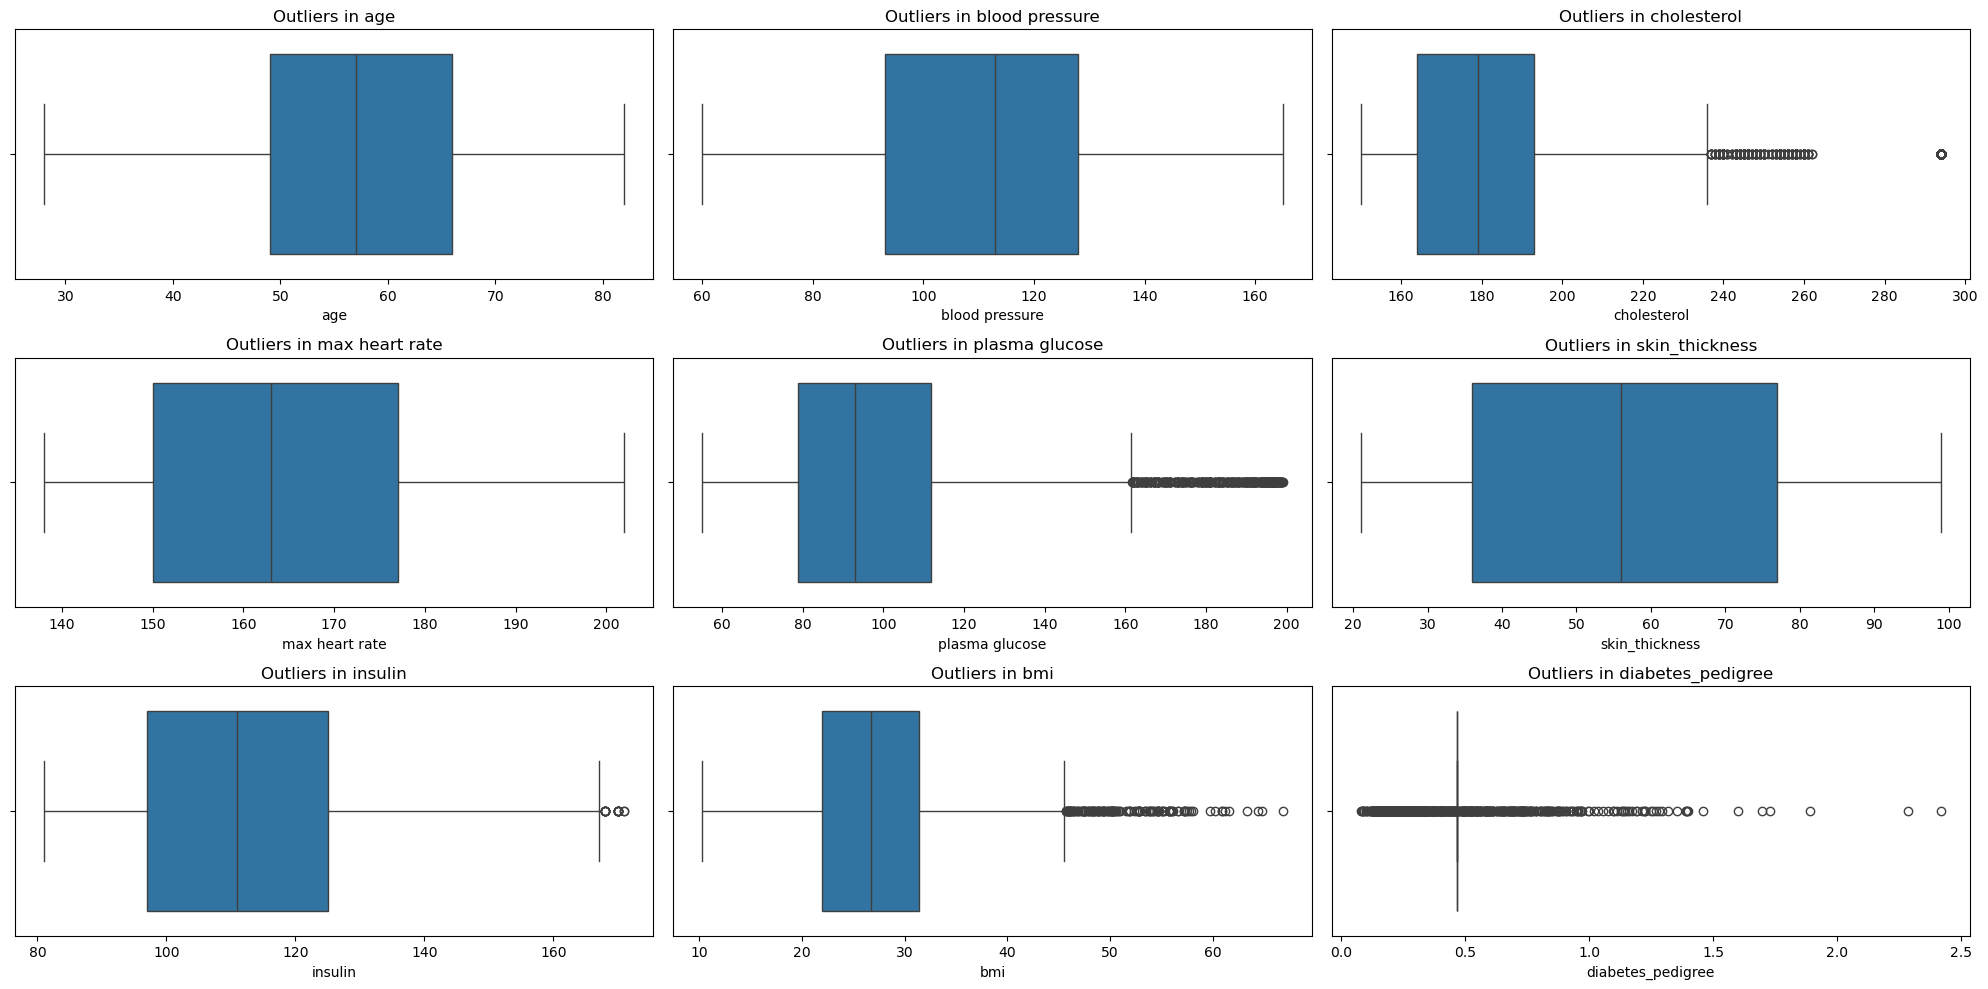

In [13]:
num_cols = ['age', 'blood pressure', 'cholesterol', 'max heart rate', 
            'plasma glucose', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree']

plt.figure(figsize=(20, 10))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=df[col])
    plt.title(f"Outliers in {col}")
plt.tight_layout()
plt.show()

In [9]:
# Encode specified categorical variables
df = pd.get_dummies(df, columns=['Residence_type', 'smoking_status', 'triage'], drop_first=False)

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Check if 'triage_' columns exist (they may have already been dropped)
if any('triage_' in col for col in df.columns):
    # Encode 'triage' back to single column (assumes previous one-hot encoding was done for EDA)
    df['triage'] = df[[col for col in df.columns if 'triage_' in col]].idxmax(axis=1)
    df['triage'] = df['triage'].str.replace('triage_', '')
    # Drop previous one-hot 'triage' columns
    df = df.drop(columns=[col for col in df.columns if 'triage_' in col])

# Encode target to numeric
le = LabelEncoder()
df['triage'] = le.fit_transform(df['triage'])

# Separate features and target
X = df.drop(columns=['triage'])
y = df['triage']

# Print the number of cases in each triage level before SMOTE
print("Before SMOTE:")
print(y.value_counts())

# Resample using SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Print the number of cases in each triage level after SMOTE
print("After SMOTE:")
print(pd.Series(y_resampled).value_counts())





Before SMOTE:
triage
3    5637
0     440
1     346
2     129
Name: count, dtype: int64
After SMOTE:
triage
3    5637
1    5637
2    5637
0    5637
Name: count, dtype: int64


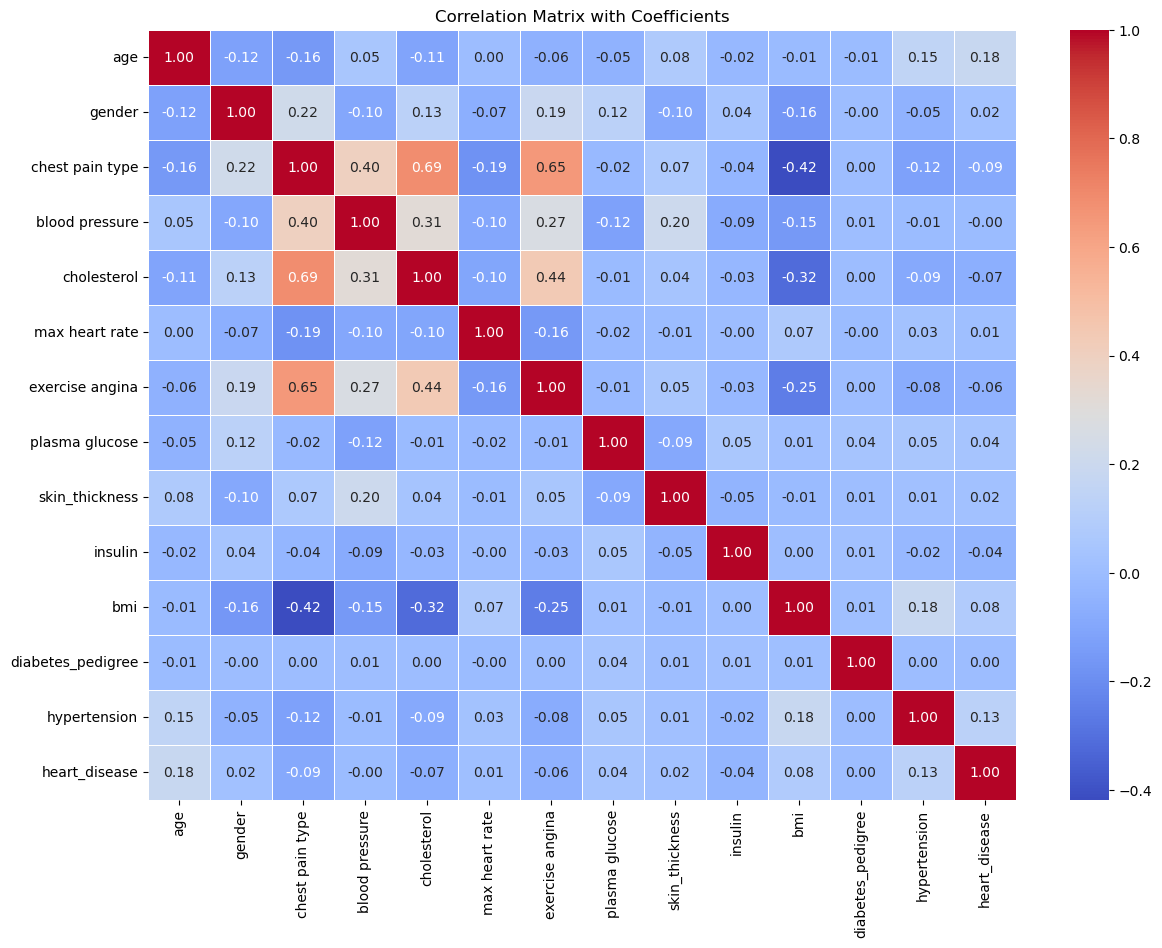

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Restore original df for EDA (with triage as labels again)
df_eda = df.copy()
df_eda['triage_label'] = le.inverse_transform(df_eda['triage'])

plt.figure(figsize=(14, 10))
corr_matrix = df_eda.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix with Coefficients")
plt.show()


C:\Users\MSii\AppData\Local\Temp\ipykernel_10648\4199962012.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_numeric_triage, x='gender', y='triage', ci=None)


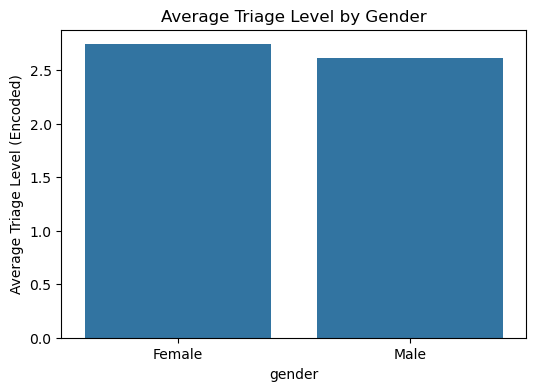

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Restore original df for EDA (with triage as labels again)
df_eda = df.copy()
df_eda['triage_label'] = le.inverse_transform(df_eda['triage'])

#Average Triage Level by Gender (numerical encoding)
# Note: This requires triage to be numeric (e.g., red=0, orange=1, yellow=2, green=3)
df_numeric_triage = df.copy()
df_numeric_triage['triage'] = df_numeric_triage['triage'].astype(int)

plt.figure(figsize=(6, 4))
sns.barplot(data=df_numeric_triage, x='gender', y='triage', ci=None)
plt.title("Average Triage Level by Gender")
plt.xticks([0, 1], ["Female", "Male"])
plt.ylabel("Average Triage Level (Encoded)")
plt.show()


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(model, X_train, X_test, y_train, y_test):
    from sklearn.metrics import mean_squared_error
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}")
    print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
    print(f"Test R²: {r2_score(y_test, y_test_pred):.4f}")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
print("Random Forest Performance:")
evaluate_model(rf, X_train_scaled, X_test_scaled, y_train, y_test)

Random Forest Performance:
Train R²: 0.9994
Train RMSE: 0.0265
Test R²: 0.9982
Test RMSE: 0.0479


In [25]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train_scaled, y_train)
print("Gradient Boosting Performance:")
evaluate_model(gb, X_train_scaled, X_test_scaled, y_train, y_test)


Gradient Boosting Performance:
Train R²: 0.9863
Train RMSE: 0.1306
Test R²: 0.9840
Test RMSE: 0.1415


In [27]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train_scaled, y_train)
print("Support Vector Regression Performance:")
evaluate_model(svr, X_train_scaled, X_test_scaled, y_train, y_test)

Support Vector Regression Performance:
Train R²: 0.9042
Train RMSE: 0.3460
Test R²: 0.8920
Test RMSE: 0.3679


Confusion Matrix:
[[1119    0    0    0]
 [   0 1158    0    0]
 [   0    0 1089    0]
 [   0    7    0 1137]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1119
           1       0.99      1.00      1.00      1158
           2       1.00      1.00      1.00      1089
           3       1.00      0.99      1.00      1144

    accuracy                           1.00      4510
   macro avg       1.00      1.00      1.00      4510
weighted avg       1.00      1.00      1.00      4510



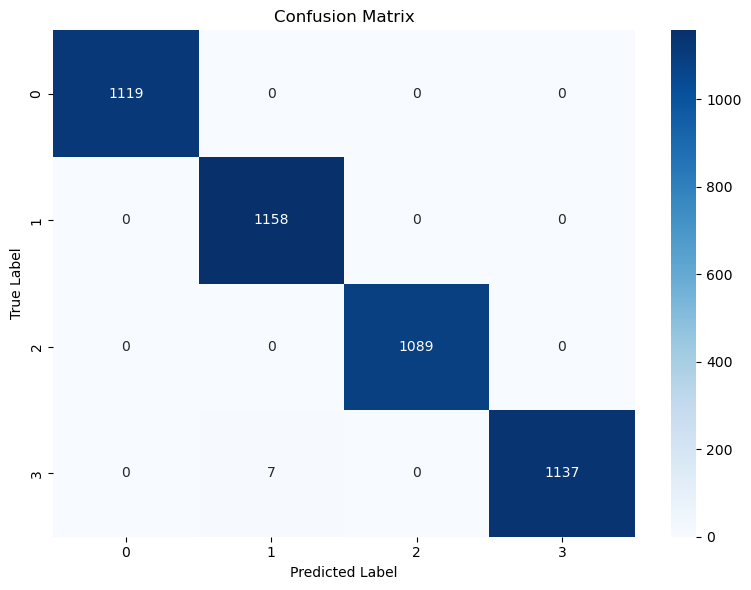

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

#Fit initial Random Forest for feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

#Feature Selection based on importance
selector = SelectFromModel(rf, prefit=True, threshold="median")  # Keep features above median importance
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

#Fit new model with selected features
rf_selected = RandomForestClassifier(random_state=42)
rf_selected.fit(X_train_selected, y_train)
#Evaluate using confusion matrix
y_pred = rf_selected.predict(X_test_selected)

#Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred, labels=rf_selected.classes_)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_selected.classes_,
            yticklabels=rf_selected.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

import pandas as pd
import numpy as np

# Get feature importances and names
importances = rf.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False)








In [31]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import pandas as pd

from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(model, X_train, X_test, y_train, y_test):
    from sklearn.metrics import mean_squared_error
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}")
    print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
    print(f"Test R²: {r2_score(y_test, y_test_pred):.4f}")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")

# Convert scaled arrays back to DataFrames with column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

selected_features = ['plasma glucose', 'blood pressure', 'age', 'bmi', 'chest pain type', 'gender']
X_train_selected = X_train_scaled_df[selected_features]
X_test_selected = X_test_scaled_df[selected_features]
#Fit model using RandomForestRegressor on selected features
rf_selected = RandomForestRegressor(random_state=42)
rf_selected.fit(X_train_selected, y_train)

#Evaluate the selected-features model
print("\nEvaluating Feature-Selected Model:")
evaluate_model(rf_selected, X_train_selected, X_test_selected, y_train, y_test)

#For comparison: Fit model on full feature set
rf_regressor_original = RandomForestRegressor(random_state=42)
rf_regressor_original.fit(X_train_scaled, y_train)

print("\nEvaluating Original Model:")
evaluate_model(rf_regressor_original, X_train_scaled, X_test_scaled, y_train, y_test)






Evaluating Feature-Selected Model:
Train R²: 0.9990
Train RMSE: 0.0358
Test R²: 0.9912
Test RMSE: 0.1052

Evaluating Original Model:
Train R²: 0.9994
Train RMSE: 0.0265
Test R²: 0.9982
Test RMSE: 0.0479


Silhouette Score: 0.19419258626378924


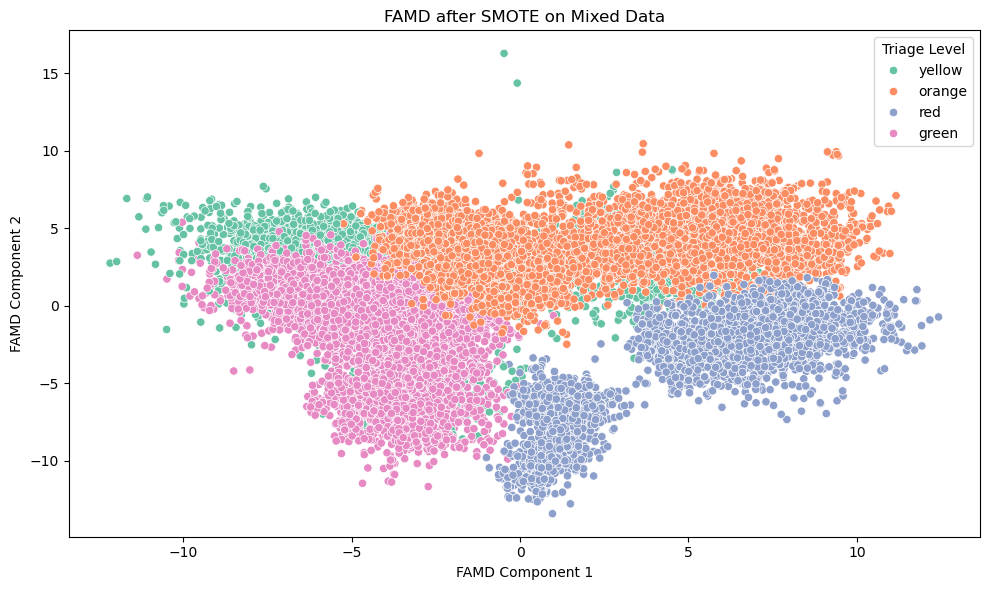

In [62]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
import prince  # For FAMD
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("patient_priority.csv")
df = df.dropna(subset=['triage'])  # Drop missing target rows

#Handle Missing Values
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('triage')

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

#Encode Categorical Variables
encoded_df = df.copy()
le_dict = {}

for col in cat_cols + ['triage']:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(encoded_df[col])
    le_dict[col] = le

X = encoded_df.drop(columns=['triage'])
y = encoded_df['triage']

#Apply SMOTENC
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

smote_nc = SMOTENC(categorical_features=cat_indices, random_state=42)
X_res, y_res = smote_nc.fit_resample(X, y)

#Recombine into Resampled DataFrame
df_resampled = pd.DataFrame(X_res, columns=X.columns)
df_resampled['triage'] = y_res

#Decode categorical variables (optional)
for col in cat_cols + ['triage']:
    df_resampled[col] = le_dict[col].inverse_transform(df_resampled[col].astype(int))

#Apply FAMD
famd = prince.FAMD(n_components=2, random_state=42)
famd = famd.fit(df_resampled)

famd_coords = famd.row_coordinates(df_resampled)
famd_coords['triage'] = df_resampled['triage']

#Silhouette Score to check cluster separation
triage_numeric = LabelEncoder().fit_transform(df_resampled['triage'])
score = silhouette_score(famd_coords[[0, 1]], triage_numeric)
print("Silhouette Score:", score)

#FAMD Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=famd_coords, x=0, y=1, hue='triage', palette='Set2')
plt.title("FAMD after SMOTE on Mixed Data")
plt.xlabel("FAMD Component 1")
plt.ylabel("FAMD Component 2")
plt.legend(title='Triage Level')
plt.tight_layout()
plt.show()


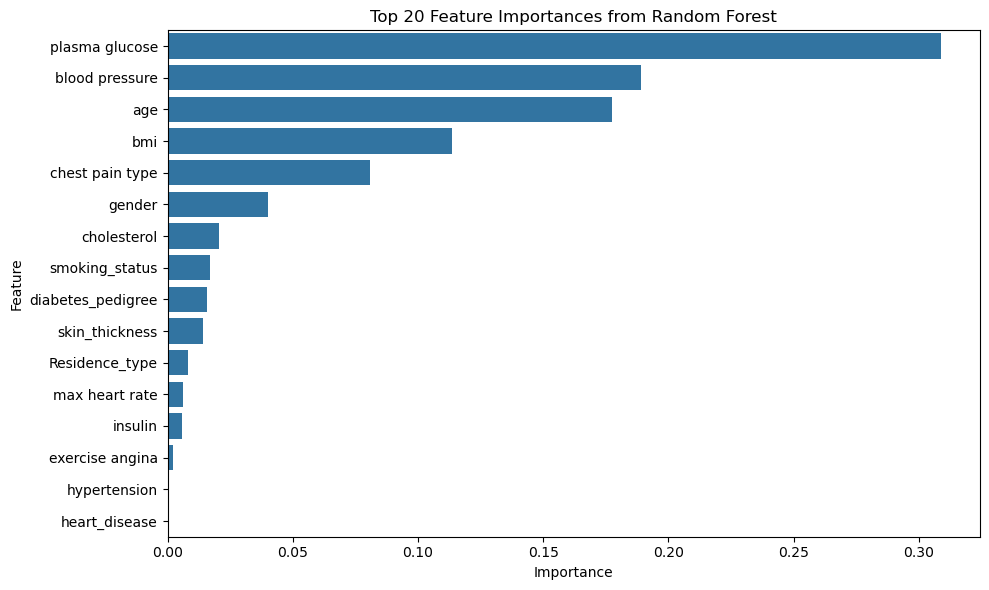


Evaluating Feature-Selected Model:
Train R²: 0.9990
Train RMSE: 0.0360
Test R²: 0.9903
Test RMSE: 0.1101

Evaluating Original Model:
Train R²: 0.9994
Train RMSE: 0.0280
Test R²: 0.9967
Test RMSE: 0.0648


In [110]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import pandas as pd

from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(model, X_train, X_test, y_train, y_test):
    from sklearn.metrics import mean_squared_error
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}")
    print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
    print(f"Test R²: {r2_score(y_test, y_test_pred):.4f}")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")

# Convert scaled arrays back to DataFrames with column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

import pandas as pd
import numpy as np

# Get feature importances and names
importances = rf.feature_importances_
feature_names = X_train.columns  # Or list of your feature names
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20))  # top 20
plt.title('Top 20 Feature Importances from Random Forest')
plt.tight_layout()
plt.savefig('top_20_feature_importances.png')
plt.show()


#subset using column names
selected_features = ['plasma glucose', 'blood pressure', 'age', 'bmi', 'chest pain type', 'gender']
X_train_selected = X_train_scaled_df[selected_features]
X_test_selected = X_test_scaled_df[selected_features]


Fit model using RandomForestRegressor on selected features
rf_selected = RandomForestRegressor(random_state=42)
rf_selected.fit(X_train_selected, y_train)

#Evaluate the selected-features model
print("\nEvaluating Feature-Selected Model:")
evaluate_model(rf_selected, X_train_selected, X_test_selected, y_train, y_test)

#For comparison: Fit model on full feature set
rf_regressor_original = RandomForestRegressor(random_state=42)
rf_regressor_original.fit(X_train_scaled, y_train)

print("\nEvaluating Original Model:")
evaluate_model(rf_regressor_original, X_train_scaled, X_test_scaled, y_train, y_test)





Evaluating Feature-Selected Classifier:

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1421
           1       0.99      1.00      0.99      1413
           2       1.00      1.00      1.00      1393
           3       1.00      0.99      0.99      1410

    accuracy                           1.00      5637
   macro avg       1.00      1.00      1.00      5637
weighted avg       1.00      1.00      1.00      5637

Confusion Matrix:
[[1421    0    0    0]
 [   0 1412    0    1]
 [   0    0 1393    0]
 [   0   21    0 1389]]


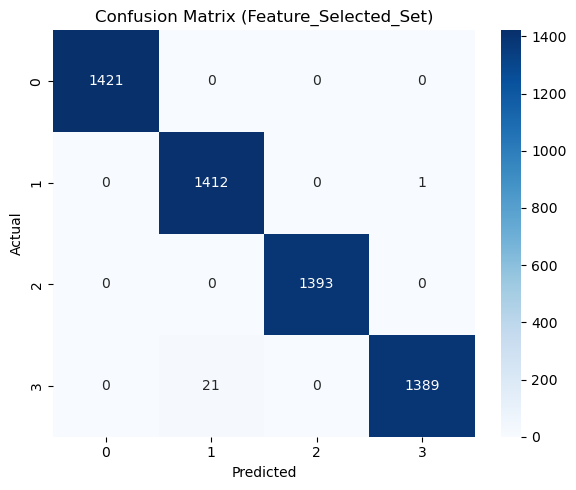


Evaluating Original Classifier:

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1421
           1       0.99      1.00      1.00      1413
           2       1.00      1.00      1.00      1393
           3       1.00      0.99      1.00      1410

    accuracy                           1.00      5637
   macro avg       1.00      1.00      1.00      5637
weighted avg       1.00      1.00      1.00      5637

Confusion Matrix:
[[1421    0    0    0]
 [   0 1413    0    0]
 [   0    0 1393    0]
 [   0    9    0 1401]]


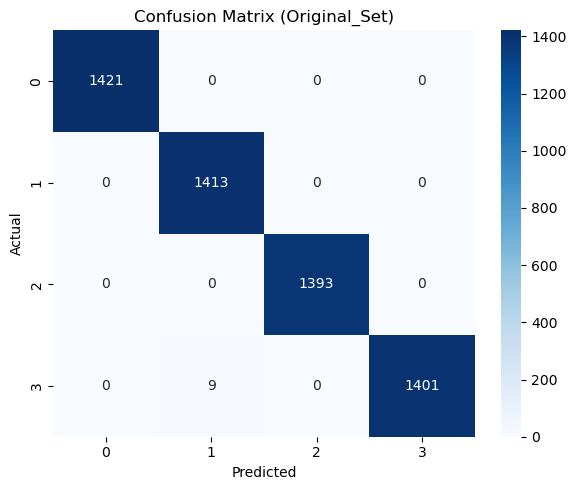

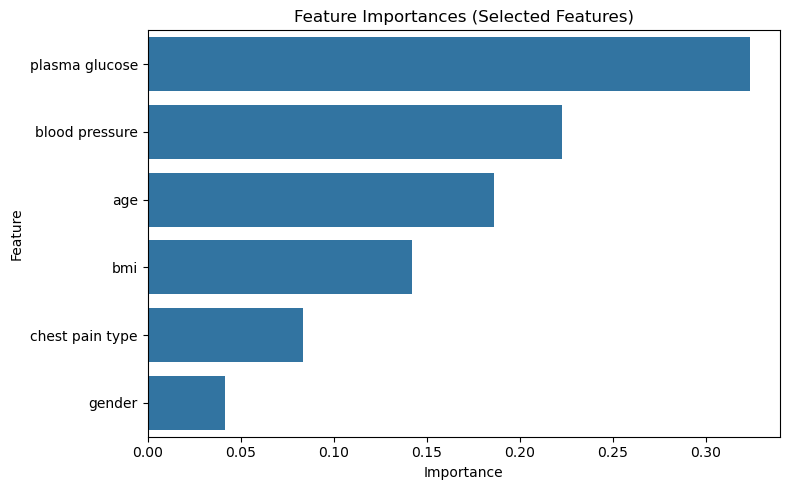

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Updated evaluation function for classification
def evaluate_model(model, X_train, X_test, y_train, y_test, feature_set_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred, labels=model.classes_)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=model.classes_,
                yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({feature_set_name})")
    plt.tight_layout()
    plt.show()  # Display confusion matrix

# Ensure column names from original data
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# Select the desired subset of features
selected_features = ['plasma glucose', 'blood pressure', 'age', 'bmi', 'chest pain type', 'gender']
X_train_selected = X_train_scaled_df[selected_features]
X_test_selected = X_test_scaled_df[selected_features]

# Fit RandomForestClassifier on selected features
rf_selected = RandomForestClassifier(random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Evaluate the selected-features model
print("\nEvaluating Feature-Selected Classifier:")
evaluate_model(rf_selected, X_train_selected, X_test_selected, y_train, y_test, "Feature_Selected_Set")

# For comparison: Fit classifier on full feature set
rf_original = RandomForestClassifier(random_state=42)
rf_original.fit(X_train_scaled, y_train)

print("\nEvaluating Original Classifier:")
evaluate_model(rf_original, X_train_scaled, X_test_scaled, y_train, y_test, "Original_Set")

# Feature importance plot for selected features
importances = rf_selected.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title("Feature Importances (Selected Features)")
plt.tight_layout()
plt.show() 


In [112]:
import pandas as pd
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)


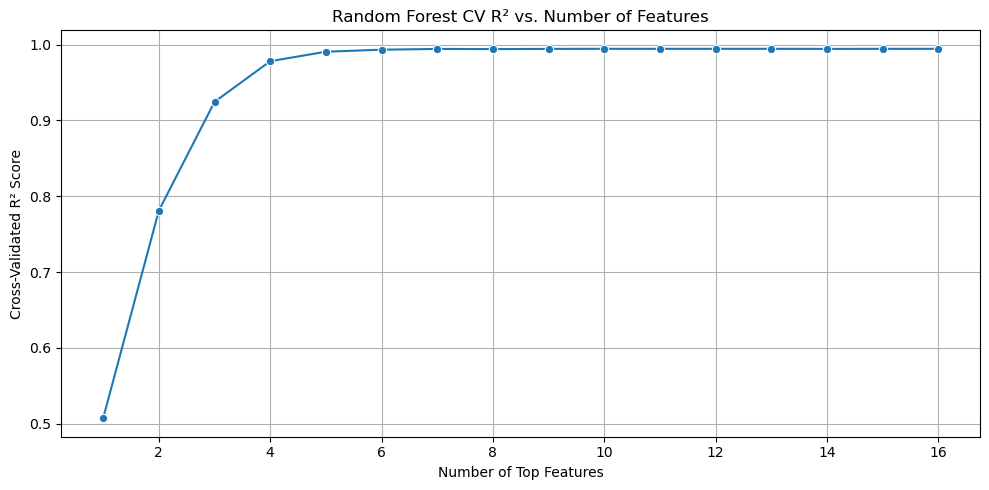

In [114]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#Fit model and extract feature importances
rf_full = RandomForestRegressor(random_state=42)
rf_full.fit(X_train_scaled_df, y_train)

importances = rf_full.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': X_train_scaled_df.columns, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False).reset_index(drop=True)

#Perform cross-validation using increasing numbers of features
cv_scores = []
feature_counts = list(range(1, min(21, len(feat_imp_df) + 1)))  # Try top 1 to 20 features

for k in feature_counts:
    top_k_features = feat_imp_df['Feature'].iloc[:k].tolist()
    X_k = X_train_scaled_df[top_k_features]
    scores = cross_val_score(RandomForestRegressor(random_state=42), X_k, y_train, cv=5, scoring='r2')
    cv_scores.append(scores.mean())

#Plot R² vs number of features
plt.figure(figsize=(10, 5))
sns.lineplot(x=feature_counts, y=cv_scores, marker='o')
plt.xlabel('Number of Top Features')
plt.ylabel('Cross-Validated R² Score')
plt.title('Random Forest CV R² vs. Number of Features')
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
#Checking Multicolinearity 
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load Data
df = pd.read_csv("patient_priority.csv")
df = df.dropna(subset=['triage'])

# Identify Numeric Columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Exclude:
# 1. Binary variables (0/1 only)
# 2. 'chest pain type' variable (categorical with 4 levels)
num_cols_vif = [col for col in num_cols if (df[col].nunique() > 2) and (col.lower() != 'chest pain type')]

# Handle Missing Values
df[num_cols_vif] = df[num_cols_vif].fillna(df[num_cols_vif].median())

# VIF Calculation
vif_data = pd.DataFrame()
vif_data['Feature'] = num_cols_vif
vif_data['VIF'] = [variance_inflation_factor(df[num_cols_vif].values, i) for i in range(len(num_cols_vif))]

print("VIF Values (Continuous Variables Only - Excluding Binary & Chest Pain Type):")
print(vif_data)

VIF Values (Continuous Variables Only - Excluding Binary & Chest Pain Type):
             Feature        VIF
0                age  23.385507
1     blood pressure  30.094621
2        cholesterol  34.771100
3     max heart rate  69.209340
4     plasma glucose  12.297812
5     skin_thickness   7.520141
6            insulin  35.904967
7                bmi  14.935544
8  diabetes_pedigree  22.328747
